In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

im_path = '232202.png'


In [2]:
def circle_detection(im_path, stp=3, num_circles=5, eps=1, min_radius=10):
    ## stp reslolution and step of the loops in parameter space
    ## num_circles number of returned circles
    ## eps tolerance / error of the circle equation
    
    # get image both gray and color, we process on gray
    img = cv2.imread(im_path, 0)
    img_color = cv2.cvtColor(cv2.imread(im_path),cv2.COLOR_BGR2RGB)

    # detect edges, canny filter returns 0 or 255. No need filtering on max*thd
    edges = cv2.Canny(img, 50, 150, apertureSize = 3)
    M = edges.shape

    # getting peaks for edges
    peaks = np.argwhere(edges==255)
    xs, ys = peaks.T

    # getting image searching options with stp size, x is the row number, y is the column number
    a_y, a_x= np.meshgrid(range(0, M[1],stp), range(0, M[0],stp))
    r = int( max(M[0]/2, M[1]/2) )
    r_range = range(0, r, stp)
    step_y, step_x = np.meshgrid(range(a_x.shape[1]), range(a_x.shape[0]))

    # getting accumlated counter
    acc = np.zeros([step_y.shape[0],step_y.shape[1],len(r_range)])

    # drawing circles for possible center locations
    t = time.time()

    for (i, x) in enumerate(xs):
        # calculate distance square
        dist_sq = (a_x-x)**2 + (a_y-ys[i])**2
        # calucate distance (rounded)
        dist = (np.sqrt(dist_sq)).astype(np.int16)
        # filter if the distance is above the eps
        mask_eps = np.abs(dist_sq - dist**2) <= eps
        # filter if the distance is larger than the max radius allowed
        mask_dst_max = dist < r
        mask_dst_min = dist > min_radius
        # filter if the distance is between the step size
        mask_stp = (dist%stp == 0)
        # create overall mask
        mask = mask_eps * mask_dst_max * mask_dst_min * mask_stp
        # accumulate the result is any circle found
        if mask.sum()<1:
            continue
        new_circle = np.zeros_like(acc)
        new_circle[step_x[mask],step_y[mask],(dist[mask]//stp)] = 1
        acc  = acc + new_circle
    duration = time.time()-t
    print(f"Processing taking {duration}s")
    
    # plot top circls
    acc_current = acc.copy()
    fig, axes = plt.subplots(num_circles,1, figsize=(num_circles*4,20))
    for i in range(num_circles):
        ind = np.unravel_index(np.argmax(acc_current, axis=None), acc.shape)
        print(f"Top {i+1} circle [center_x, center_y, radius]: {[i*3 for i in ind]}")
        img2 = img_color.copy()
        img2 = cv2.circle(img2, (ind[1]*stp,ind[0]*stp), ind[2]*stp, (255,0,255), 4)
        axes[i].imshow(img2)
        acc_current[ind] = 0
    
    return acc


In [3]:
def circle_detection_nms(im_path, stp=3, num_circles=5, eps=1, suprression_range=3, min_radius=10):
    ## stp reslolution and step of the loops in parameter space
    ## num_circles number of returned circles
    ## eps tolerance / error of the circle equation
    
    # get image both gray and color, we process on gray
    img = cv2.imread(im_path, 0)
    img_color = cv2.cvtColor(cv2.imread(im_path),cv2.COLOR_BGR2RGB)

    # detect edges, canny filter returns 0 or 255. No need filtering on max*thd
    edges = cv2.Canny(img, 50, 150, apertureSize = 3)
    M = edges.shape

    # getting peaks for edges
    peaks = np.argwhere(edges==255)
    xs, ys = peaks.T

    # getting image searching options with stp size, x is the row number, y is the column number
    a_y, a_x= np.meshgrid(range(0, M[1],stp), range(0, M[0],stp))
    r = int( max(M[0]/2, M[1]/2) )
    r_range = range(0, r, stp)
    step_y, step_x = np.meshgrid(range(a_x.shape[1]), range(a_x.shape[0]))

    # getting accumlated counter
    acc = np.zeros([step_y.shape[0],step_y.shape[1],len(r_range)])

    # drawing circles for possible center locations
    t = time.time()

    for (i, x) in enumerate(xs):
        # calculate distance square
        dist_sq = (a_x-x)**2 + (a_y-ys[i])**2
        # calucate distance (rounded)
        dist = (np.sqrt(dist_sq)).astype(np.int16)
        # filter if the distance is above the eps
        mask_eps = np.abs(dist_sq - dist**2) <= eps
        # filter if the distance is larger than the max radius allowed
        mask_dst_max = dist < r
        mask_dst_min = dist > min_radius
        # filter if the distance is between the step size
        mask_stp = (dist%stp == 0)
        # create overall mask
        mask = mask_eps * mask_dst_max * mask_dst_min * mask_stp
        # accumulate the result is any circle found
        if mask.sum()<1:
            continue
        new_circle = np.zeros_like(acc)
        new_circle[step_x[mask],step_y[mask],(dist[mask]//stp)] = 1
        acc  = acc + new_circle
    duration = time.time()-t
    print(f"Processing taking {duration}s")
    
    # plot top circls
    acc_current = acc.copy()
    fig, axes = plt.subplots(num_circles,1, figsize=(num_circles*4,20))
    for i in range(num_circles):
        ind = np.unravel_index(np.argmax(acc_current, axis=None), acc.shape)
        print(f"Top {i+1} circle [center_x, center_y, radius]: {[i*3 for i in ind]}")
        img2 = img_color.copy()
        img2 = cv2.circle(img2, (ind[1]*stp,ind[0]*stp), ind[2]*stp, (255,0,255), 4)
        axes[i].imshow(img2)
        x_start = max(0, ind[0]-suprression_range)
        x_end = min(M[0], ind[0]+suprression_range)
        y_start = max(0, ind[1]-suprression_range)
        y_end = min(M[1], ind[1]+suprression_range)
        r_start = max(0, ind[2]-suprression_range)
        r_end = min(r, ind[2]+suprression_range)
        acc_current[x_start:x_end,y_start:y_end, r_start:r_end] = 0
    
    return acc

Processing taking 1.6794710159301758s
Top 1 circle [center_x, center_y, radius]: [201, 135, 57]
Top 2 circle [center_x, center_y, radius]: [306, 78, 30]
Top 3 circle [center_x, center_y, radius]: [300, 150, 45]
Top 4 circle [center_x, center_y, radius]: [303, 78, 27]
Top 5 circle [center_x, center_y, radius]: [312, 150, 57]


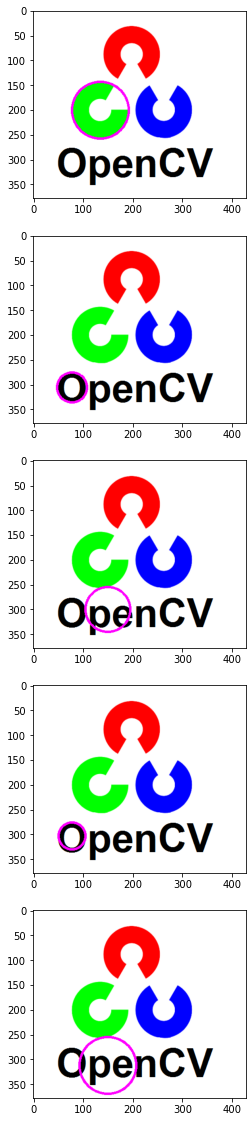

In [4]:
acc_3 = circle_detection(im_path, stp=3)

Processing taking 1.7209758758544922s
Top 1 circle [center_x, center_y, radius]: [201, 135, 57]
Top 2 circle [center_x, center_y, radius]: [306, 78, 30]
Top 3 circle [center_x, center_y, radius]: [300, 150, 45]
Top 4 circle [center_x, center_y, radius]: [312, 150, 57]
Top 5 circle [center_x, center_y, radius]: [90, 198, 57]


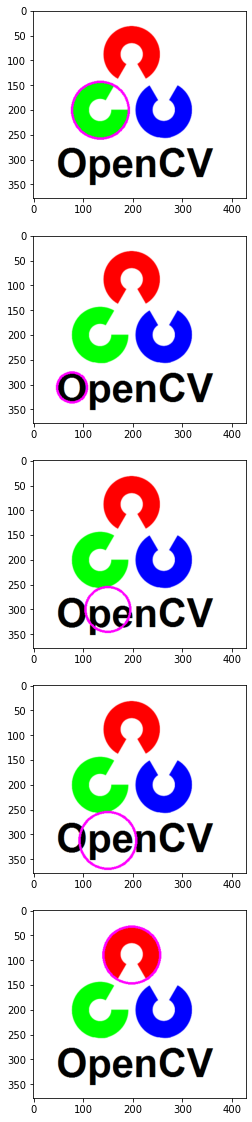

In [5]:
acc_3_nms = circle_detection_nms(im_path)

Processing taking 20.137659072875977s
Top 1 circle [center_x, center_y, radius]: [132, 297, 33]
Top 2 circle [center_x, center_y, radius]: [459, 117, 45]
Top 3 circle [center_x, center_y, radius]: [465, 204, 27]
Top 4 circle [center_x, center_y, radius]: [465, 270, 27]
Top 5 circle [center_x, center_y, radius]: [459, 429, 48]


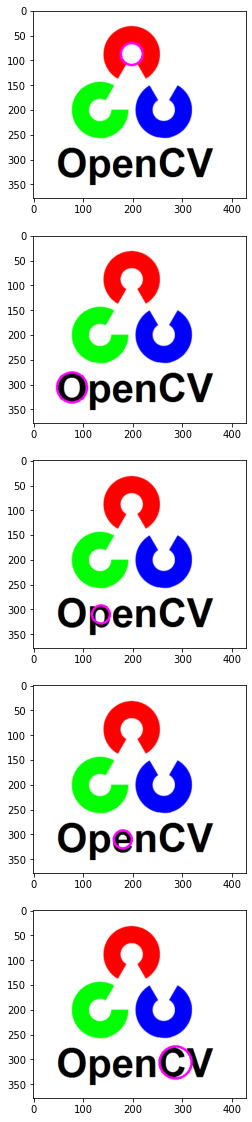

In [6]:
acc_2_nms = circle_detection_nms(im_path, stp=2)

Processing taking 338.21482706069946s
Top 1 circle [center_x, center_y, radius]: [600, 786, 171]
Top 2 circle [center_x, center_y, radius]: [267, 594, 171]
Top 3 circle [center_x, center_y, radius]: [600, 405, 171]
Top 4 circle [center_x, center_y, radius]: [264, 594, 66]
Top 5 circle [center_x, center_y, radius]: [918, 234, 90]


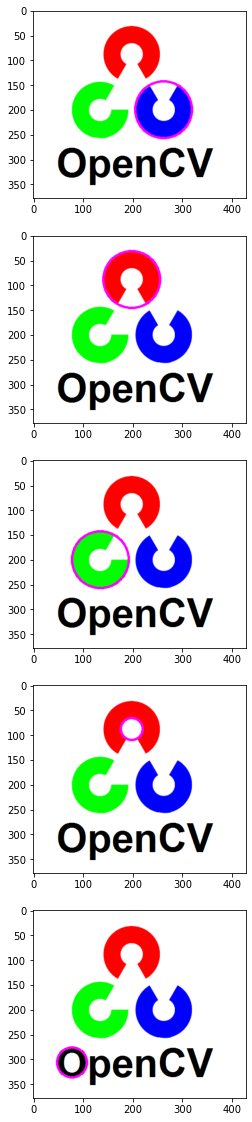

In [7]:
acc_1_nms = circle_detection_nms(im_path, stp=1)

Processing taking 92.02796077728271s
Top 1 circle [center_x, center_y, radius]: [459, 708, 33]
Top 2 circle [center_x, center_y, radius]: [591, 471, 30]
Top 3 circle [center_x, center_y, radius]: [459, 522, 33]
Top 4 circle [center_x, center_y, radius]: [459, 708, 84]
Top 5 circle [center_x, center_y, radius]: [603, 471, 30]


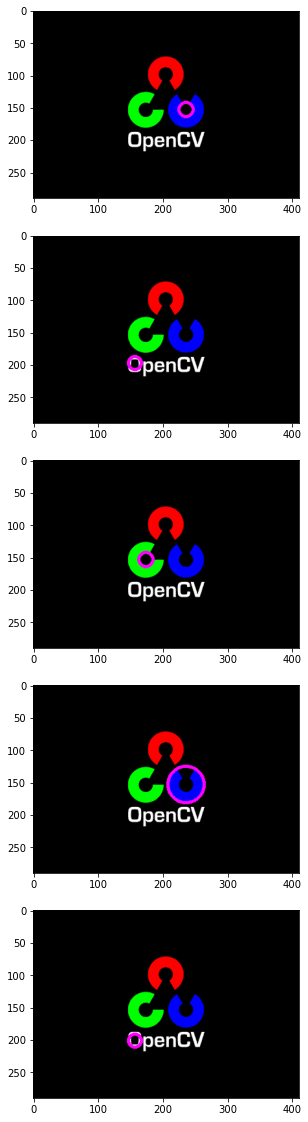

In [12]:
im2_1_nms = circle_detection_nms('95103cv4.bmp', stp=1, eps=10, min_radius=5)

Processing taking 21.98909592628479s
Top 1 circle [center_x, center_y, radius]: [417, 384, 279]
Top 2 circle [center_x, center_y, radius]: [402, 402, 294]
Top 3 circle [center_x, center_y, radius]: [411, 423, 279]
Top 4 circle [center_x, center_y, radius]: [426, 402, 294]
Top 5 circle [center_x, center_y, radius]: [390, 405, 300]


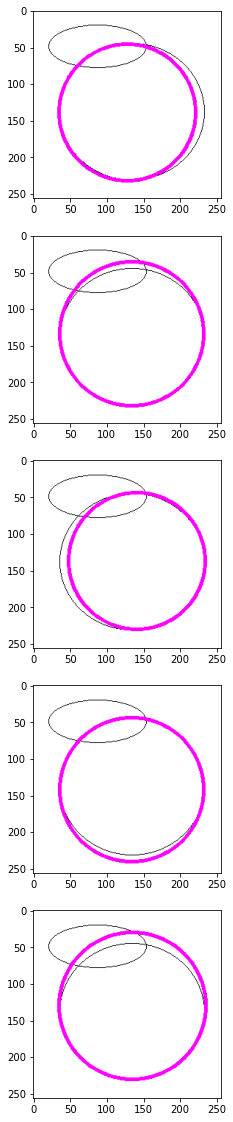

In [10]:
im3_1_nms = circle_detection_nms('circles4.bmp', stp=1)

Processing taking 50.71647000312805s
Top 1 circle [center_x, center_y, radius]: [381, 171, 108]
Top 2 circle [center_x, center_y, radius]: [264, 393, 108]
Top 3 circle [center_x, center_y, radius]: [468, 462, 108]
Top 4 circle [center_x, center_y, radius]: [501, 459, 108]
Top 5 circle [center_x, center_y, radius]: [504, 459, 108]


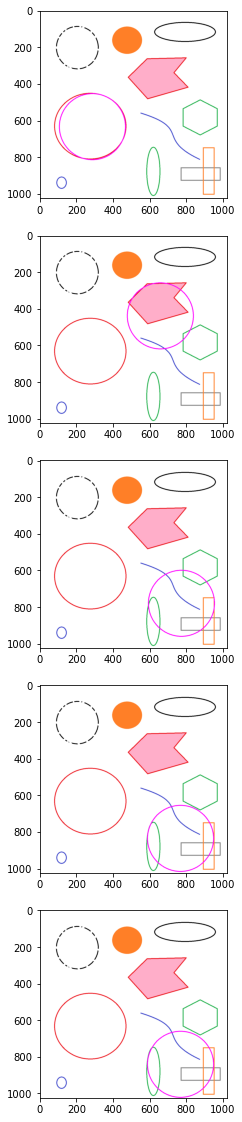

In [7]:
im4_1_nms = circle_detection('circles1.bmp', stp=5, min_radius=175)

Processing taking 86.87742304801941s
Top 1 circle [center_x, center_y, radius]: [381, 171, 108]
Top 2 circle [center_x, center_y, radius]: [381, 174, 108]
Top 3 circle [center_x, center_y, radius]: [378, 171, 108]
Top 4 circle [center_x, center_y, radius]: [381, 168, 108]
Top 5 circle [center_x, center_y, radius]: [504, 459, 108]


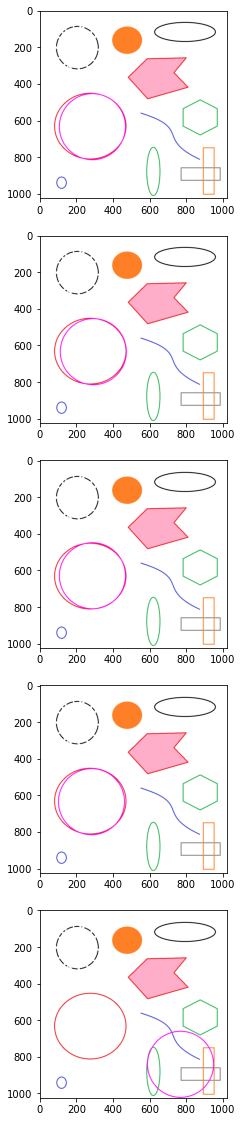

In [8]:
im4_1_nms = circle_detection('circles1.bmp', stp=5, eps=10, min_radius=175)


Processing taking 185.52388191223145s
Top 1 circle [center_x, center_y, radius]: [477, 192, 135]
Top 2 circle [center_x, center_y, radius]: [471, 201, 135]
Top 3 circle [center_x, center_y, radius]: [474, 219, 132]
Top 4 circle [center_x, center_y, radius]: [183, 588, 135]
Top 5 circle [center_x, center_y, radius]: [183, 600, 135]


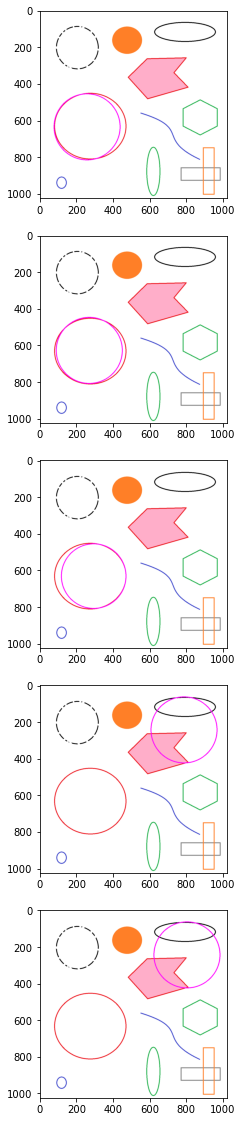

In [10]:
im4_1_nms = circle_detection_nms('circles1.bmp', stp=4, eps=10, min_radius=175)

Processing taking 182.43231916427612s
Top 1 circle [center_x, center_y, radius]: [477, 192, 135]
Top 2 circle [center_x, center_y, radius]: [471, 192, 135]
Top 3 circle [center_x, center_y, radius]: [471, 201, 135]
Top 4 circle [center_x, center_y, radius]: [474, 192, 135]
Top 5 circle [center_x, center_y, radius]: [477, 189, 132]


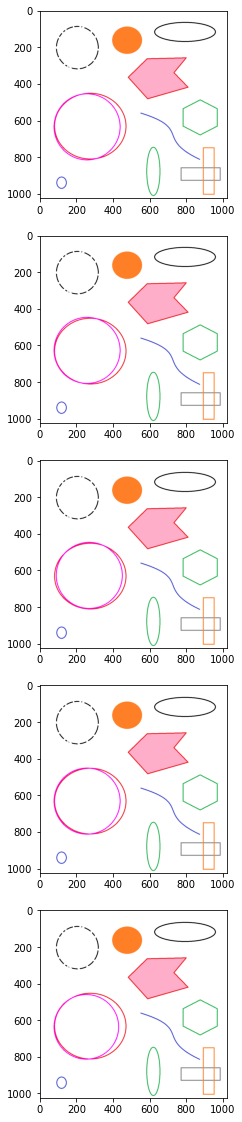

In [9]:
im4_1_nms = circle_detection('circles1.bmp', stp=4, eps=10, min_radius=175)


Processing taking 50.782562017440796s
Top 1 circle [center_x, center_y, radius]: [381, 171, 108]
Top 2 circle [center_x, center_y, radius]: [264, 393, 108]
Top 3 circle [center_x, center_y, radius]: [468, 462, 108]
Top 4 circle [center_x, center_y, radius]: [501, 459, 108]
Top 5 circle [center_x, center_y, radius]: [552, 459, 108]


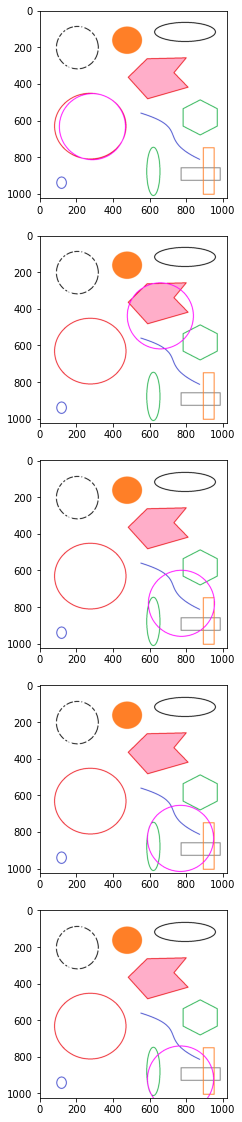

In [6]:
im4_1_nms = circle_detection_nms('circles1.bmp', stp=5, min_radius=175)